Cell 1: Importing Dependencies Importing necessary libraries for data manipulation, visualization, and machine learning operations.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
print("Setup Complete!")

Setup Complete!


Cell 2: Loading the Dataset Loading the customer support dataset from the CSV file and displaying the initial structure.

In [26]:
file_path = 'customer_support_tickets.csv'

try:
    data = pd.read_csv(file_path)
    print("Data Loaded Successfully!")
    print(f"Total Rows: {data.shape[0]}")
    print(f"Total Columns: {data.shape[1]}")
except FileNotFoundError:
    print("File not found. Please upload 'customer_support_tickets.csv'.")

# Show the first few rows to check structure
data.head()

Data Loaded Successfully!
Total Rows: 8469
Total Columns: 17


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


Cell 3: Data Inspection Checking the dataset for missing values and understanding the data types of each column.

In [27]:
df_closed = df[df['Customer Satisfaction Rating'].notna()].copy()
print(f"Closed tickets with ratings: {len(df_closed)}")

# Convert date columns
df_closed['Date of Purchase'] = pd.to_datetime(df_closed['Date of Purchase'], errors='coerce')
df_closed['First Response Time'] = pd.to_datetime(df_closed['First Response Time'], errors='coerce')
df_closed['Time to Resolution'] = pd.to_datetime(df_closed['Time to Resolution'], errors='coerce')

# Calculate time features (hours)
df_closed['First_Response_Hrs'] = (df_closed['First Response Time'] - df_closed['Date of Purchase']).dt.total_seconds() / 3600
df_closed['Resolution_Hrs'] = (df_closed['Time to Resolution'] - df_closed['Date of Purchase']).dt.total_seconds() / 3600

# Drop unnecessary columns
cols_to_drop = ['Ticket ID', 'Customer Name', 'Customer Email', 'Ticket Description',
                'Resolution', 'Date of Purchase', 'First Response Time', 'Time to Resolution']
df_clean = df_closed.drop(columns=cols_to_drop)

print("Clean dataset shape:", df_clean.shape)
print("\nClean data preview:")
display(df_clean.head())

Closed tickets with ratings: 2769
Clean dataset shape: (2769, 11)

Clean data preview:


,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Subject,Ticket Status,Ticket Priority,Ticket Channel,Customer Satisfaction Rating,First_Response_Hrs,Resolution_Hrs
2,48,Other,Dell XPS,Technical issue,Network problem,Closed,Low,Social media,3.0,25259.243889,25266.093889
3,27,Female,Microsoft Office,Billing inquiry,Account access,Closed,Low,Social media,3.0,22327.494444,22321.961111
4,67,Female,Autodesk AutoCAD,Billing inquiry,Data loss,Closed,Low,Email,1.0,29112.211667,29131.895000
10,48,Male,Nintendo Switch,Cancellation request,Data loss,Closed,High,Phone,1.0,20729.780278,20711.863611
11,51,Male,Microsoft Xbox Controller,Product inquiry,Software bug,Closed,High,Chat,1.0,14052.097500,14049.464167


In [28]:
# Cell 3: Dataset Info & Missing Values Analysis
print("--- Data Info ---")
data.info()

print("\n--- Missing Values Count ---")
print(data.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null 

Cell 4: Data Cleaning Filtering the data to include only closed tickets that have a valid customer satisfaction rating.

In [29]:
# We only want tickets that are 'Closed' and have a rating
clean_df = data[data['Ticket Status'] == 'Closed'].copy()
clean_df = clean_df.dropna(subset=['Customer Satisfaction Rating'])

print(f"Rows after filtering closed tickets: {clean_df.shape[0]}")

Rows after filtering closed tickets: 2769


Cell 5: Feature Engineering Converting date columns to the correct format and calculating response delay and resolution time in hours.

In [30]:
# Convert columns to datetime format
date_cols = ['Date of Purchase', 'First Response Time', 'Time to Resolution']
for col in date_cols:
    clean_df[col] = pd.to_datetime(clean_df[col], errors='coerce')

# Create new features: Delay in Hours
clean_df['Response_Delay_Hours'] = (clean_df['First Response Time'] - clean_df['Date of Purchase']).dt.total_seconds() / 3600
clean_df['Resolution_Time_Hours'] = (clean_df['Time to Resolution'] - clean_df['Date of Purchase']).dt.total_seconds() / 3600

# Remove columns that are not useful for prediction (IDs, Names, etc.)
drop_cols = ['Ticket ID', 'Customer Name', 'Customer Email', 'Ticket Description',
             'Resolution', 'Date of Purchase', 'First Response Time', 'Time to Resolution']
final_data = clean_df.drop(columns=drop_cols)

final_data.head()

,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Subject,Ticket Status,Ticket Priority,Ticket Channel,Customer Satisfaction Rating,Response_Delay_Hours,Resolution_Time_Hours
2,48,Other,Dell XPS,Technical issue,Network problem,Closed,Low,Social media,3.0,25259.243889,25266.093889
3,27,Female,Microsoft Office,Billing inquiry,Account access,Closed,Low,Social media,3.0,22327.494444,22321.961111
4,67,Female,Autodesk AutoCAD,Billing inquiry,Data loss,Closed,Low,Email,1.0,29112.211667,29131.895000
10,48,Male,Nintendo Switch,Cancellation request,Data loss,Closed,High,Phone,1.0,20729.780278,20711.863611
11,51,Male,Microsoft Xbox Controller,Product inquiry,Software bug,Closed,High,Chat,1.0,14052.097500,14049.464167


Cell 6: Correlation Analysis Visualizing relationships between different numerical variables using a heatmap to identify patterns.

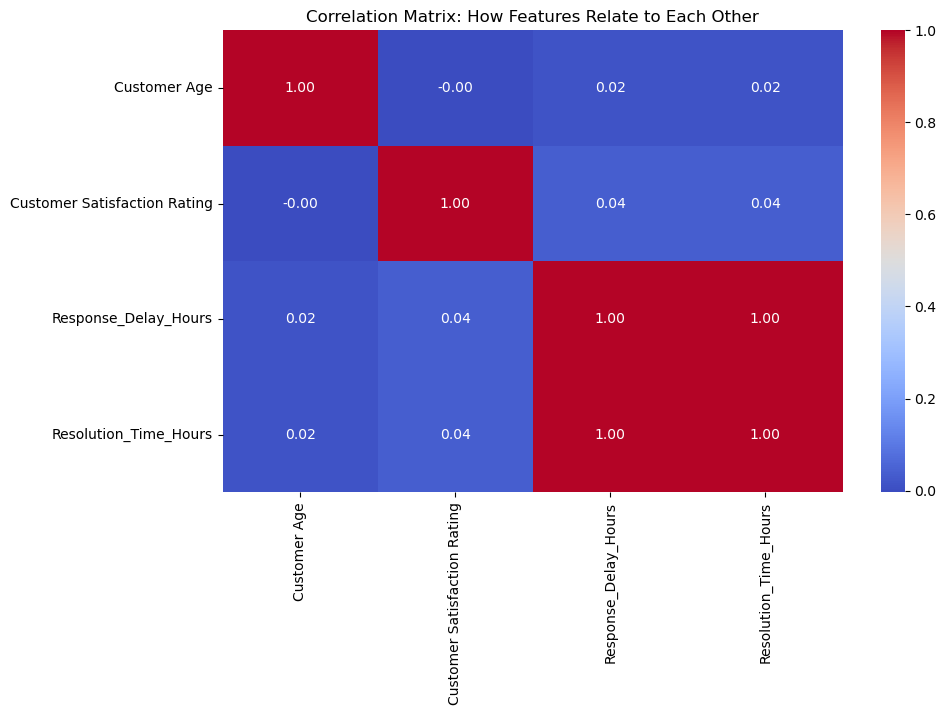

In [31]:
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation
numeric_data = final_data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: How Features Relate to Each Other')
plt.show()

Cell 7: Target Variable Distribution Plotting the count of different customer satisfaction ratings to check for data balance.

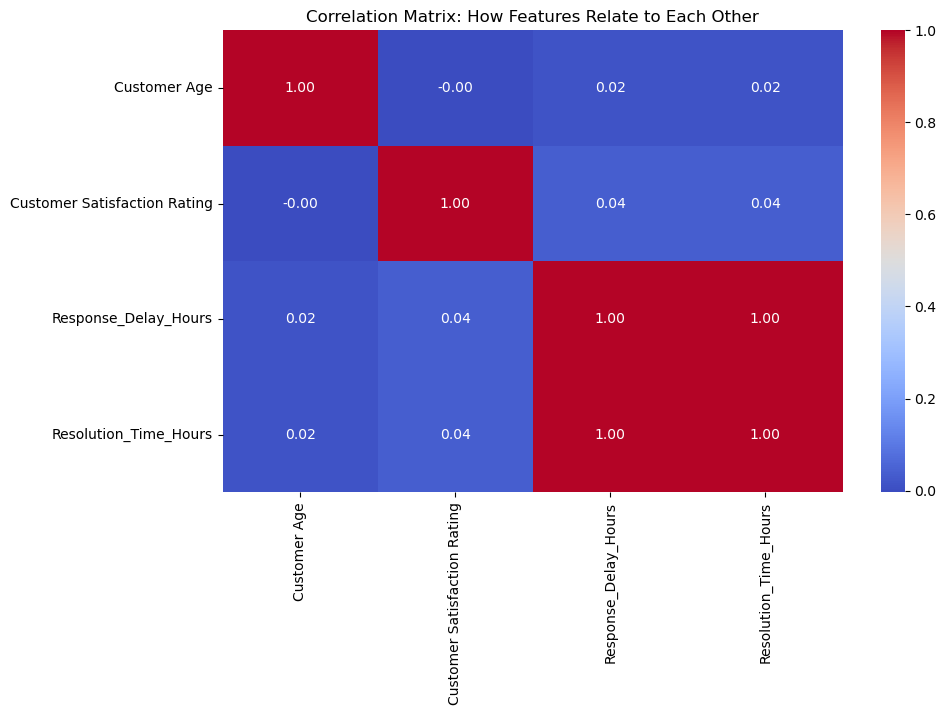

In [32]:
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation
numeric_data = final_data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: How Features Relate to Each Other')
plt.show()

Cell 8: Encoding Categorical Variables Converting text-based categorical columns into numerical format using label encoding for model training.

In [33]:
categorical_cols = ['Customer Gender', 'Product Purchased', 'Ticket Type',
                    'Ticket Subject', 'Ticket Status', 'Ticket Priority', 'Ticket Channel']

encoder = LabelEncoder()

for col in categorical_cols:
    final_data[col] = encoder.fit_transform(final_data[col].astype(str))
    print(f"Converted '{col}' to numbers.")

print("\nData ready for AI Training!")
final_data.head()

Converted 'Customer Gender' to numbers.
Converted 'Product Purchased' to numbers.
Converted 'Ticket Type' to numbers.
Converted 'Ticket Subject' to numbers.
Converted 'Ticket Status' to numbers.
Converted 'Ticket Priority' to numbers.
Converted 'Ticket Channel' to numbers.

Data ready for AI Training!


,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Subject,Ticket Status,Ticket Priority,Ticket Channel,Customer Satisfaction Rating,Response_Delay_Hours,Resolution_Time_Hours
2,48,2,10,4,8,0,2,3,3.0,25259.243889,25266.093889
3,27,0,25,0,0,0,2,3,3.0,22327.494444,22321.961111
4,67,0,5,0,3,0,2,1,1.0,29112.211667,29131.895000
10,48,1,30,1,3,0,1,2,1.0,20729.780278,20711.863611
11,51,1,27,2,15,0,1,0,1.0,14052.097500,14049.464167


Cell 9: Train-Test Split Splitting the dataset into training and testing sets to evaluate model performance on unseen data.

In [34]:
X = final_data.drop(columns=['Customer Satisfaction Rating']) # Features
y = final_data['Customer Satisfaction Rating'] # Target

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

Training Samples: 2215
Testing Samples: 554


Cell 10: Model Comparison Training both Decision Tree and Random Forest classifiers to compare their accuracy and select the best one.

In [35]:
from sklearn.tree import DecisionTreeClassifier

# 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

# 2. Random Forest Classifier (More powerful)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"Decision Tree Accuracy: {dt_acc * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")

if rf_acc > dt_acc:
    print("\n✅ Conclusion: Random Forest performed better. We will use it for final analysis.")
    final_model = rf_model
    final_pred = rf_pred
else:
    final_model = dt_model
    final_pred = dt_pred

Decision Tree Accuracy: 22.02%
Random Forest Accuracy: 23.29%

✅ Conclusion: Random Forest performed better. We will use it for final analysis.


Cell 11: Final Model Evaluation Generating a classification report and confusion matrix to evaluate the detailed performance of the selected model.

--- Classification Report ---
              precision    recall  f1-score   support

         1.0       0.21      0.22      0.22       109
         2.0       0.24      0.23      0.23       117
         3.0       0.24      0.27      0.25       112
         4.0       0.23      0.20      0.21       108
         5.0       0.25      0.24      0.25       108

    accuracy                           0.23       554
   macro avg       0.23      0.23      0.23       554
weighted avg       0.23      0.23      0.23       554



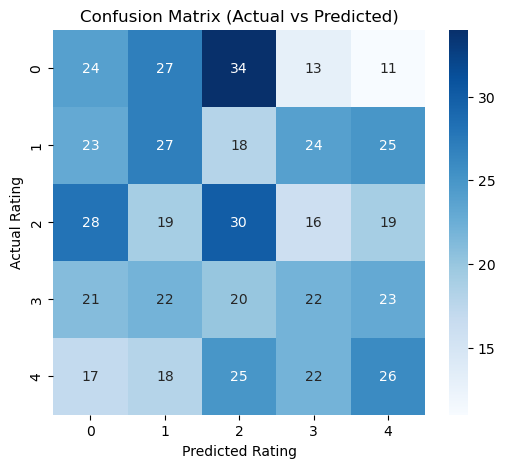

In [36]:
print("--- Classification Report ---")
print(classification_report(y_test, final_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, final_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Actual vs Predicted)')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

Cell 12: Feature Importance Analysis Identifying and plotting the most significant factors that influence customer satisfaction scores.

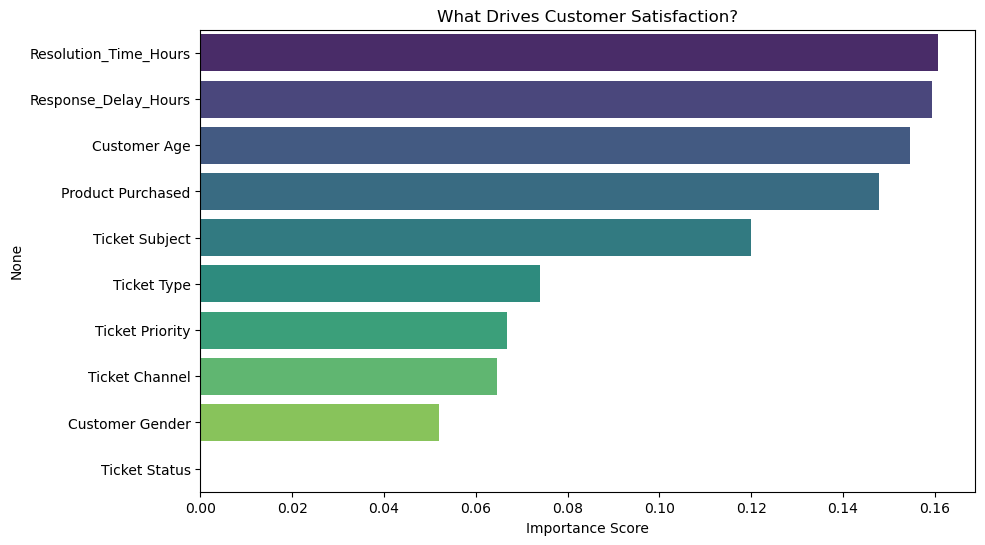

In [37]:
import pandas as pd

feature_imp = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.title('What Drives Customer Satisfaction?')
plt.xlabel('Importance Score')
plt.show()